# YouTube Trending Videos Analysis
## Understanding What Makes a Video Successful

**Research Question:** What patterns and factors determine a video's success on YouTube?

This notebook analyzes trending YouTube videos across multiple countries to identify:
- Key engagement metrics and patterns
- Optimal publishing strategies
- Category performance differences
- Factors correlating with video success

## 0. Install Required Dependencies

Run this cell first to install all necessary packages.

In [12]:
# Install required packages
%pip install pandas numpy matplotlib seaborn

print("\n✓ All packages installed successfully!")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

✓ All packages installed successfully!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Libraries and Setup

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Data Loading Functions

We'll create reusable functions to load and process data from multiple countries.

In [14]:
def load_category_mapping(country_code):
    """
    Load category ID to name mapping from JSON file.
    
    Parameters:
    country_code (str): Two-letter country code (e.g., 'US', 'CA')
    
    Returns:
    dict: Mapping of category_id to category_name
    """
    try:
        with open(f'../dataset/{country_code}_category_id.json', 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        category_map = {}
        for item in data['items']:
            category_map[int(item['id'])] = item['snippet']['title']
        
        return category_map
    except FileNotFoundError:
        print(f"Warning: Category file for {country_code} not found")
        return {}

def load_videos_data(country_code):
    """
    Load video data for a specific country.
    
    Parameters:
    country_code (str): Two-letter country code
    
    Returns:
    DataFrame: Video data with country column added
    """
    try:
        df = pd.read_csv(f'../dataset/{country_code}videos.csv', 
                        encoding='utf-8', 
                        on_bad_lines='skip')
        df['country'] = country_code
        return df
    except FileNotFoundError:
        print(f"Warning: Video file for {country_code} not found")
        return pd.DataFrame()

def load_all_countries(countries):
    """
    Load and combine data from multiple countries using loops.
    
    Parameters:
    countries (list): List of country codes
    
    Returns:
    tuple: (combined_df, category_mappings)
    """
    all_data = []
    all_categories = {}
    
    # Loop through each country
    for country in countries:
        print(f"Loading data for {country}...")
        
        # Load videos
        df = load_videos_data(country)
        if not df.empty:
            all_data.append(df)
        
        # Load categories
        categories = load_category_mapping(country)
        if categories:
            all_categories[country] = categories
    
    # Combine all dataframes
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n✓ Loaded {len(combined_df):,} videos from {len(countries)} countries")
        return combined_df, all_categories
    else:
        return pd.DataFrame(), {}

# Test with a few countries
countries_to_analyze = ['US', 'CA', 'GB', 'IN']
df_raw, category_maps = load_all_countries(countries_to_analyze)

Loading data for US...
Loading data for CA...
Loading data for GB...
Loading data for IN...

✓ Loaded 158,098 videos from 4 countries


## 3. Initial Data Exploration

In [15]:
# Display basic information
print("Dataset Shape:", df_raw.shape)
print("\nColumn Names and Types:")
print(df_raw.dtypes)
print("\nFirst few rows:")
df_raw.head()

Dataset Shape: (158098, 17)

Column Names and Types:
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
country                   object
dtype: object

First few rows:


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,US
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US


In [16]:
# Check for missing values
print("Missing Values Summary:")
missing_summary = df_raw.isnull().sum()
missing_pct = (missing_summary / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values Summary:
             Missing Count  Percentage
description           3039        1.92


## 4. Data Cleaning and Wrangling

Now we'll clean the data by handling missing values, duplicates, and data type conversions.

In [17]:
def clean_video_data(df):
    """
    Clean and preprocess video data using conditionals and data transformations.
    
    Parameters:
    df (DataFrame): Raw video data
    
    Returns:
    DataFrame: Cleaned video data
    """
    df_clean = df.copy()
    
    print("Starting data cleaning process...")
    print(f"Initial shape: {df_clean.shape}")
    
    # 1. Handle missing values based on conditions
    if 'description' in df_clean.columns:
        df_clean['description'] = df_clean['description'].fillna('')
    
    if 'tags' in df_clean.columns:
        df_clean['tags'] = df_clean['tags'].fillna('[none]')
    
    # Drop rows with missing critical values
    critical_columns = ['video_id', 'views', 'likes', 'dislikes']
    for col in critical_columns:
        if col in df_clean.columns:
            before = len(df_clean)
            df_clean = df_clean.dropna(subset=[col])
            dropped = before - len(df_clean)
            if dropped > 0:
                print(f"  Dropped {dropped} rows with missing {col}")
    
    # 2. Remove duplicates
    before_dup = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['video_id', 'trending_date'], keep='first')
    print(f"  Removed {before_dup - len(df_clean)} duplicate entries")
    
    # 3. Convert data types
    # Convert numeric columns
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # 4. Parse dates
    if 'trending_date' in df_clean.columns:
        # Trending date format: yy.dd.mm
        df_clean['trending_date'] = pd.to_datetime(df_clean['trending_date'], format='%y.%d.%m', errors='coerce')
    
    if 'publish_time' in df_clean.columns:
        df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')
    
    # 5. Remove rows with negative or zero engagement (data quality issue)
    for col in ['views', 'likes']:
        if col in df_clean.columns:
            before = len(df_clean)
            df_clean = df_clean[df_clean[col] > 0]
            dropped = before - len(df_clean)
            if dropped > 0:
                print(f"  Removed {dropped} rows with invalid {col}")
    
    print(f"Final shape: {df_clean.shape}")
    print(f"✓ Cleaning complete! Retained {len(df_clean)/len(df)*100:.1f}% of data\n")
    
    return df_clean

# Apply cleaning
df_clean = clean_video_data(df_raw)

Starting data cleaning process...
Initial shape: (158098, 17)
  Removed 19606 duplicate entries
  Removed 1368 rows with invalid likes
Final shape: (137124, 17)
✓ Cleaning complete! Retained 86.7% of data



In [18]:
# Add category names to the dataframe
def add_category_names(df, category_maps):
    """
    Add category names based on country-specific mappings.
    Uses conditional logic to handle different countries.
    """
    df_with_cats = df.copy()
    
    # Create a function to map category for each row
    def get_category_name(row):
        country = row['country']
        cat_id = row['category_id']
        
        # Use if-statements to check country and get appropriate mapping
        if country in category_maps:
            if cat_id in category_maps[country]:
                return category_maps[country][cat_id]
        return 'Unknown'
    
    df_with_cats['category_name'] = df_with_cats.apply(get_category_name, axis=1)
    
    print(f"✓ Added category names")
    print(f"  Categories found: {df_with_cats['category_name'].nunique()}")
    print(f"  Distribution:\n{df_with_cats['category_name'].value_counts().head(10)}")
    
    return df_with_cats

df_clean = add_category_names(df_clean, category_maps)

✓ Added category names
  Categories found: 18
  Distribution:
category_name
Entertainment           42909
Music                   22726
News & Politics         11802
People & Blogs          11479
Comedy                  10810
Howto & Style            8000
Film & Animation         7058
Sports                   6899
Science & Technology     4017
Education                3897
Name: count, dtype: int64


## 5. Feature Engineering

Create derived metrics that help analyze video success factors.

In [19]:
def calculate_engagement_metrics(df):
    """
    Calculate various engagement metrics using numpy operations.
    
    Parameters:
    df (DataFrame): Cleaned video data
    
    Returns:
    DataFrame: Data with additional engagement metrics
    """
    df_eng = df.copy()
    
    # 1. Engagement Rate = (likes + comments) / views
    df_eng['engagement_rate'] = (
        (df_eng['likes'] + df_eng['comment_count']) / df_eng['views']
    ) * 100
    
    # 2. Like Ratio = likes / (likes + dislikes)
    total_reactions = df_eng['likes'] + df_eng['dislikes']
    df_eng['like_ratio'] = np.where(
        total_reactions > 0,
        (df_eng['likes'] / total_reactions) * 100,
        0
    )
    
    # 3. Comment Rate = comments / views
    df_eng['comment_rate'] = (df_eng['comment_count'] / df_eng['views']) * 100
    
    # 4. Dislike Ratio
    df_eng['dislike_ratio'] = (df_eng['dislikes'] / df_eng['views']) * 100
    
    # 5. Days to trending (time between publish and trending)
    # Remove timezone info to avoid comparison errors
    trending_naive = df_eng['trending_date'].dt.tz_localize(None) if df_eng['trending_date'].dt.tz is not None else df_eng['trending_date']
    publish_naive = df_eng['publish_time'].dt.tz_localize(None) if df_eng['publish_time'].dt.tz is not None else df_eng['publish_time']
    
    df_eng['days_to_trending'] = (
        trending_naive - publish_naive
    ).dt.total_seconds() / 86400  # Convert to days
    
    # 6. Publishing time features
    df_eng['publish_hour'] = df_eng['publish_time'].dt.hour
    df_eng['publish_day_of_week'] = df_eng['publish_time'].dt.dayofweek
    df_eng['publish_month'] = df_eng['publish_time'].dt.month
    
    # 7. Text features
    df_eng['title_length'] = df_eng['title'].str.len()
    df_eng['description_length'] = df_eng['description'].str.len()
    
    # Count tags (split by |)
    df_eng['tag_count'] = df_eng['tags'].str.count('\|') + 1
    df_eng.loc[df_eng['tags'] == '[none]', 'tag_count'] = 0
    
    print("✓ Engagement metrics calculated:")
    print(f"  - Engagement rate: {df_eng['engagement_rate'].mean():.3f}%")
    print(f"  - Like ratio: {df_eng['like_ratio'].mean():.2f}%")
    print(f"  - Average days to trending: {df_eng['days_to_trending'].mean():.1f}")
    
    return df_eng

df_clean = calculate_engagement_metrics(df_clean)

✓ Engagement metrics calculated:
  - Engagement rate: 3.525%
  - Like ratio: 92.08%
  - Average days to trending: 15.8


In [20]:
def classify_video_performance(df):
    """
    Classify videos into performance categories using conditional logic.
    
    Parameters:
    df (DataFrame): Video data with engagement metrics
    
    Returns:
    DataFrame: Data with performance classification
    """
    df_class = df.copy()
    
    # Calculate percentiles for classification
    view_75 = df_class['views'].quantile(0.75)
    view_90 = df_class['views'].quantile(0.90)
    eng_75 = df_class['engagement_rate'].quantile(0.75)
    
    # Classification logic using if-elif-else structure
    def classify_video(row):
        views = row['views']
        engagement = row['engagement_rate']
        
        # Viral: High views AND high engagement
        if views >= view_90 and engagement >= eng_75:
            return 'Viral'
        # Popular: High views OR high engagement
        elif views >= view_75 or engagement >= eng_75:
            return 'Popular'
        # Moderate: Average performance
        else:
            return 'Moderate'
    
    df_class['performance_class'] = df_class.apply(classify_video, axis=1)
    
    print("✓ Performance classification complete:")
    print(df_class['performance_class'].value_counts())
    print(f"\nClassification thresholds:")
    print(f"  Viral views threshold (90th percentile): {view_90:,.0f}")
    print(f"  Popular views threshold (75th percentile): {view_75:,.0f}")
    print(f"  High engagement threshold (75th percentile): {eng_75:.3f}%")
    
    return df_class

df_clean = classify_video_performance(df_clean)

✓ Performance classification complete:
performance_class
Moderate    76458
Popular     58488
Viral        2178
Name: count, dtype: int64

Classification thresholds:
  Viral views threshold (90th percentile): 3,974,780
  Popular views threshold (75th percentile): 1,322,050
  High engagement threshold (75th percentile): 4.893%


## 6. Exploratory Data Analysis (EDA)

Let's analyze patterns and relationships in the data.

In [21]:
# Summary statistics
print("="*80)
print("OVERALL STATISTICS")
print("="*80)
print(f"\nTotal videos analyzed: {len(df_clean):,}")
print(f"Countries: {df_clean['country'].nunique()}")
print(f"Unique channels: {df_clean['channel_title'].nunique():,}")
print(f"Categories: {df_clean['category_name'].nunique()}")

print("\n" + "="*80)
print("VIEW STATISTICS")
print("="*80)
print(df_clean['views'].describe())

print("\n" + "="*80)
print("ENGAGEMENT STATISTICS")
print("="*80)
eng_stats = df_clean[['engagement_rate', 'like_ratio', 'comment_rate']].describe()
print(eng_stats)

OVERALL STATISTICS

Total videos analyzed: 137,124
Countries: 4
Unique channels: 7,981
Categories: 18

VIEW STATISTICS
count    1.371240e+05
mean     2.388876e+06
std      1.056004e+07
min      5.490000e+02
25%      1.521388e+05
50%      4.348495e+05
75%      1.322050e+06
max      4.245389e+08
Name: views, dtype: float64

ENGAGEMENT STATISTICS
       engagement_rate     like_ratio   comment_rate
count    137124.000000  137124.000000  137124.000000
mean          3.525200      92.083052       0.434617
std           3.289806      10.559191       0.699974
min           0.000500       2.997118       0.000000
25%           1.139221      90.542567       0.105836
50%           2.624871      95.967219       0.253319
75%           4.892879      98.067302       0.522426
max          77.428226     100.000000      39.236518


In [22]:
# Aggregations by category
print("="*80)
print("CATEGORY ANALYSIS")
print("="*80)

category_stats = df_clean.groupby('category_name').agg({
    'video_id': 'count',
    'views': ['mean', 'median', 'max'],
    'engagement_rate': 'mean',
    'like_ratio': 'mean'
}).round(2)

category_stats.columns = ['Video Count', 'Avg Views', 'Median Views', 'Max Views', 
                          'Avg Engagement %', 'Avg Like Ratio %']
category_stats = category_stats.sort_values('Video Count', ascending=False)
print(category_stats)

CATEGORY ANALYSIS
                       Video Count   Avg Views  Median Views  Max Views  \
category_name                                                             
Entertainment                42909  1375229.04      378168.0  169884583   
Music                        22726  8500204.38     1611283.5  424538912   
News & Politics              11802   472917.21      170841.0   18994966   
People & Blogs               11479   891215.30      300476.0   33627806   
Comedy                       10810  1170575.94      607542.0   43460605   
Howto & Style                 8000   799016.67      354893.0   54155921   
Film & Animation              7058  2190821.60      623765.0   54863912   
Sports                        6899  1392111.45      390622.0   29090799   
Science & Technology          4017  1358627.59      496286.0   42799458   
Education                     3897   530393.84      268478.0   12100921   
Gaming                        3674  1250167.02      440921.0   18158133   
Pets & 

In [23]:
# Country comparison
print("\n" + "="*80)
print("COUNTRY COMPARISON")
print("="*80)

country_stats = df_clean.groupby('country').agg({
    'video_id': 'count',
    'views': 'mean',
    'engagement_rate': 'mean',
    'days_to_trending': 'mean'
}).round(2)

country_stats.columns = ['Videos', 'Avg Views', 'Avg Engagement %', 'Avg Days to Trending']
print(country_stats)


COUNTRY COMPARISON
         Videos   Avg Views  Avg Engagement %  Avg Days to Trending
country                                                            
CA        35826   804318.71              3.86                  2.97
GB        31279  5848696.06              3.68                 43.40
IN        29292   681558.34              2.43                  1.67
US        40727  2353503.62              3.90                 16.21


In [24]:
# Correlation analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation_cols = ['views', 'likes', 'dislikes', 'comment_count', 
                    'engagement_rate', 'like_ratio', 'title_length', 'tag_count']
correlation_matrix = df_clean[correlation_cols].corr()
print("\nKey correlations with views:")
print(correlation_matrix['views'].sort_values(ascending=False))


CORRELATION ANALYSIS

Key correlations with views:
views              1.000000
likes              0.801108
comment_count      0.483237
dislikes           0.408476
like_ratio         0.037922
tag_count         -0.019567
engagement_rate   -0.052362
title_length      -0.061844
Name: views, dtype: float64


## 7. Data Visualizations

Now we'll create story-driven visualizations to reveal insights about video success factors.

### Visualization 1: Views Distribution by Category (Bar Chart)

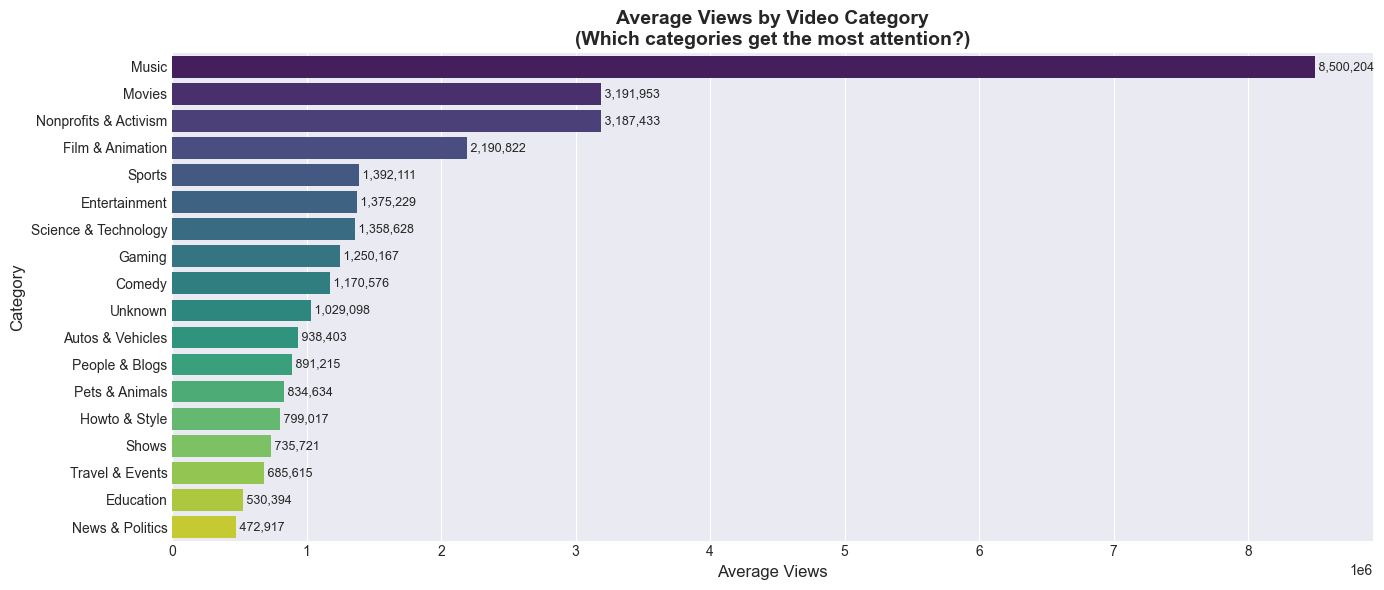


Insight: Music videos get the highest average views (8,500,204)


In [25]:
plt.figure(figsize=(14, 6))

# Calculate average views by category
cat_views = df_clean.groupby('category_name')['views'].mean().sort_values(ascending=False)

# Create bar plot
ax = sns.barplot(x=cat_views.values, y=cat_views.index, palette='viridis')
plt.xlabel('Average Views', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Average Views by Video Category\n(Which categories get the most attention?)', 
          fontsize=14, fontweight='bold')

# Add value labels
for i, v in enumerate(cat_views.values):
    ax.text(v, i, f' {v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nInsight: {cat_views.index[0]} videos get the highest average views ({cat_views.values[0]:,.0f})")

### Visualization 2: Engagement Rate vs Views (Scatter Plot)

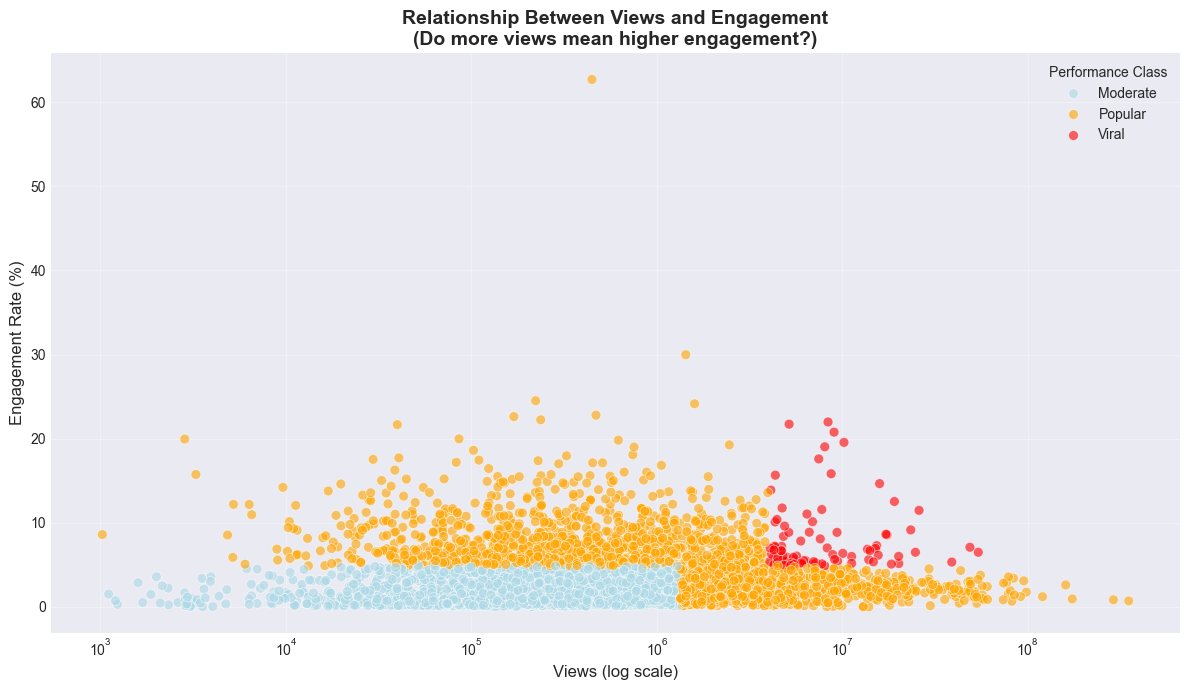

Insight: Viral videos combine both high views AND high engagement rates


In [26]:
plt.figure(figsize=(12, 7))

# Sample data for better visualization (too many points can be messy)
sample_df = df_clean.sample(n=min(5000, len(df_clean)), random_state=42)

# Create scatter plot colored by performance class
sns.scatterplot(data=sample_df, x='views', y='engagement_rate', 
                hue='performance_class', alpha=0.6, s=50,
                palette={'Viral': 'red', 'Popular': 'orange', 'Moderate': 'lightblue'})

plt.xscale('log')
plt.xlabel('Views (log scale)', fontsize=12)
plt.ylabel('Engagement Rate (%)', fontsize=12)
plt.title('Relationship Between Views and Engagement\n(Do more views mean higher engagement?)', 
          fontsize=14, fontweight='bold')
plt.legend(title='Performance Class', loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: Viral videos combine both high views AND high engagement rates")

### Visualization 3: Publishing Time Analysis (Heatmap)

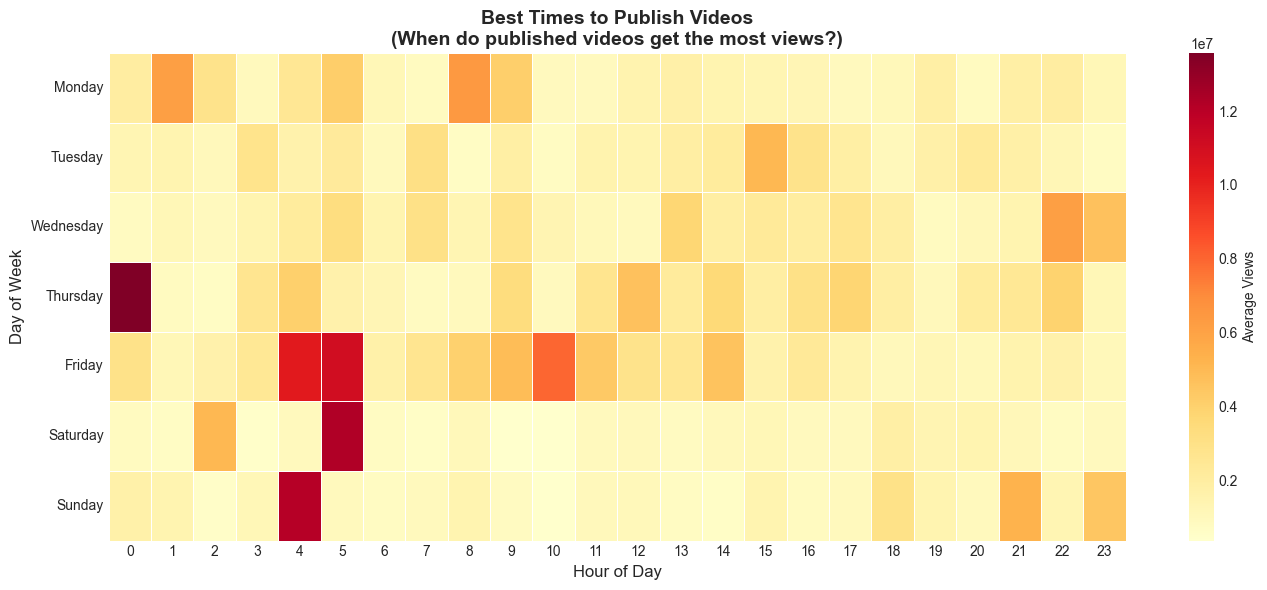


Insight: Best publishing time is Thursday at 0:00


In [27]:
plt.figure(figsize=(14, 6))

# Create pivot table for heatmap
publish_heatmap = df_clean.groupby(['publish_day_of_week', 'publish_hour'])['views'].mean().unstack()

# Create heatmap
sns.heatmap(publish_heatmap, cmap='YlOrRd', fmt='.0f', cbar_kws={'label': 'Average Views'},
            annot=False, linewidths=0.5)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           rotation=0)
plt.title('Best Times to Publish Videos\n(When do published videos get the most views?)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find best time
best_day = publish_heatmap.max(axis=1).idxmax()
best_hour = publish_heatmap.loc[best_day].idxmax()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\nInsight: Best publishing time is {days[best_day]} at {int(best_hour)}:00")

### Visualization 4: Category Performance Distribution (Box Plot)

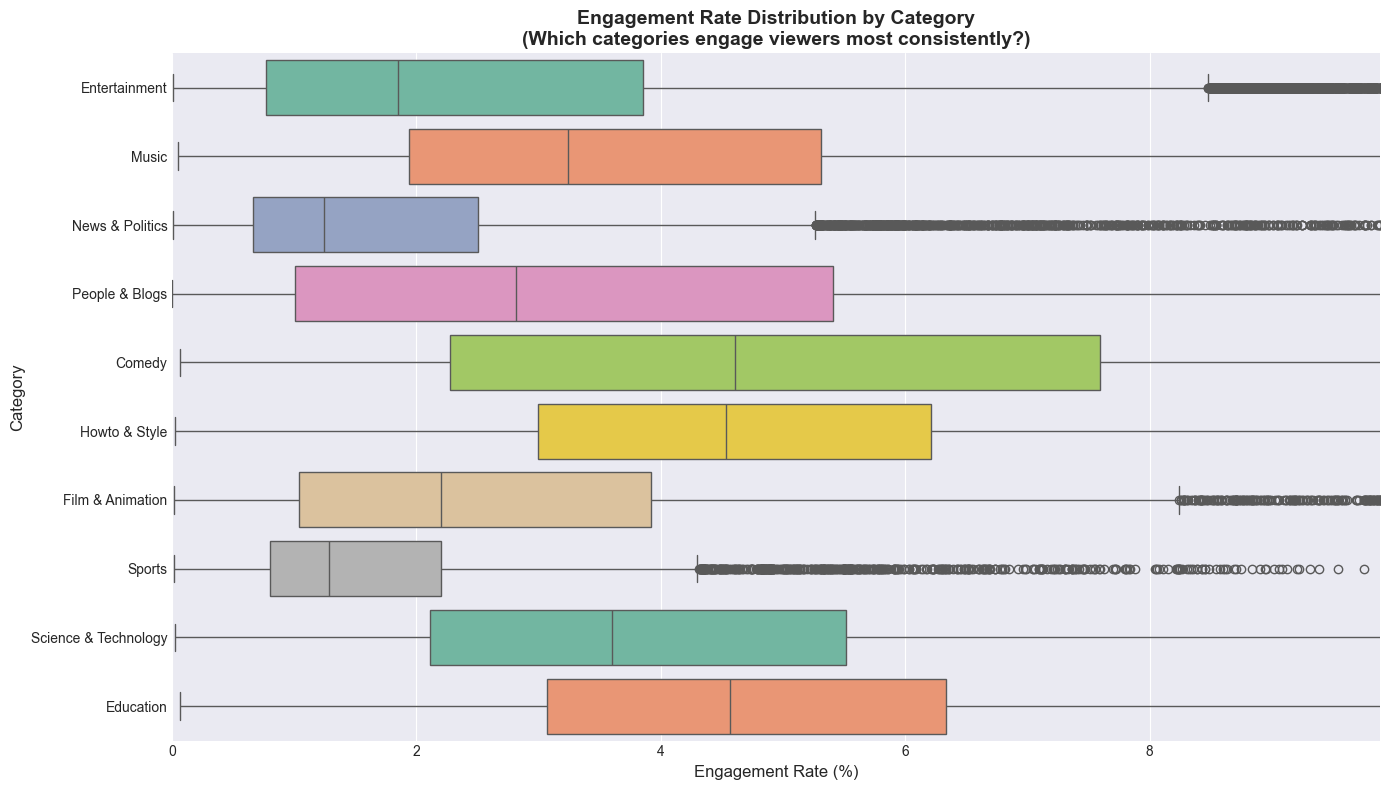

Insight: Box plots show median, spread, and outliers for each category


In [28]:
plt.figure(figsize=(14, 8))

# Get top 10 categories by count
top_categories = df_clean['category_name'].value_counts().head(10).index
df_top_cat = df_clean[df_clean['category_name'].isin(top_categories)]

# Create box plot
sns.boxplot(data=df_top_cat, y='category_name', x='engagement_rate', 
            palette='Set2', order=top_categories)

plt.xlabel('Engagement Rate (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Engagement Rate Distribution by Category\n(Which categories engage viewers most consistently?)', 
          fontsize=14, fontweight='bold')
plt.xlim(0, df_top_cat['engagement_rate'].quantile(0.95))  # Trim outliers for better view
plt.tight_layout()
plt.show()

print("Insight: Box plots show median, spread, and outliers for each category")

### Visualization 5: Like vs Dislike Correlation (Scatter Plot with Regression)

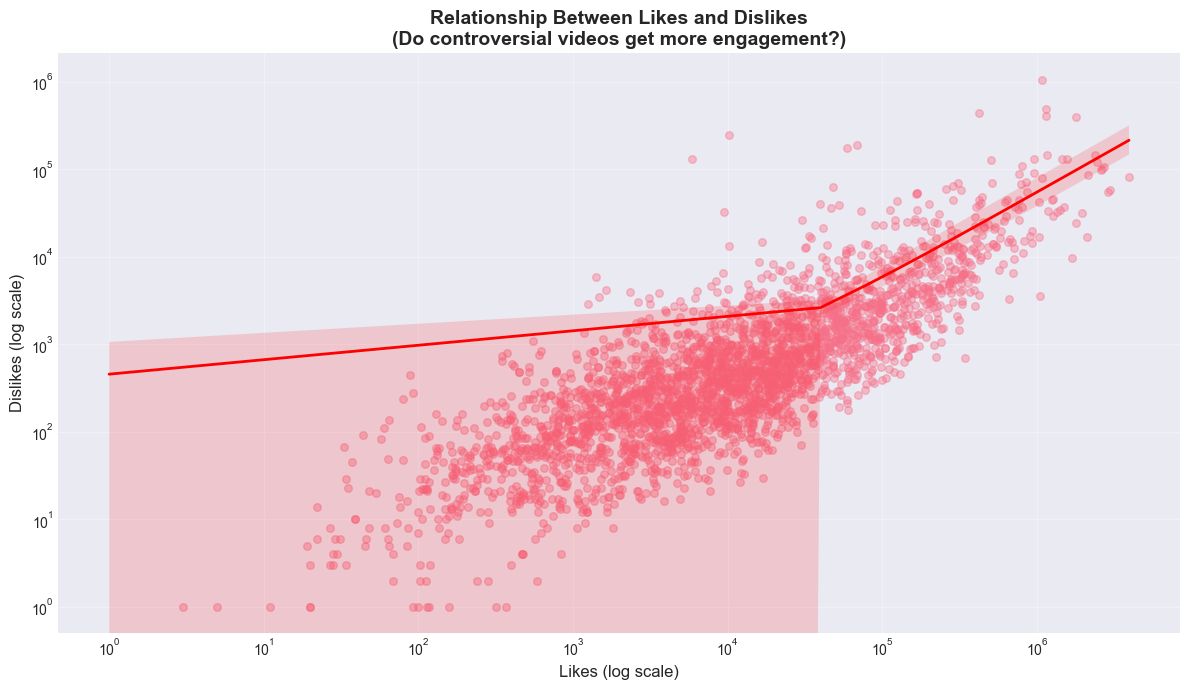

Insight: Correlation between likes and dislikes: 0.453


In [29]:
plt.figure(figsize=(12, 7))

# Sample for visualization
sample_df = df_clean.sample(n=min(3000, len(df_clean)), random_state=42)

# Create regression plot
sns.regplot(data=sample_df, x='likes', y='dislikes', 
            scatter_kws={'alpha':0.4, 's':30}, 
            line_kws={'color':'red', 'linewidth':2})

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Likes (log scale)', fontsize=12)
plt.ylabel('Dislikes (log scale)', fontsize=12)
plt.title('Relationship Between Likes and Dislikes\n(Do controversial videos get more engagement?)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = df_clean[['likes', 'dislikes']].corr().iloc[0, 1]
print(f"Insight: Correlation between likes and dislikes: {corr:.3f}")

### Visualization 6: Top Performing Channels (Horizontal Bar Chart)

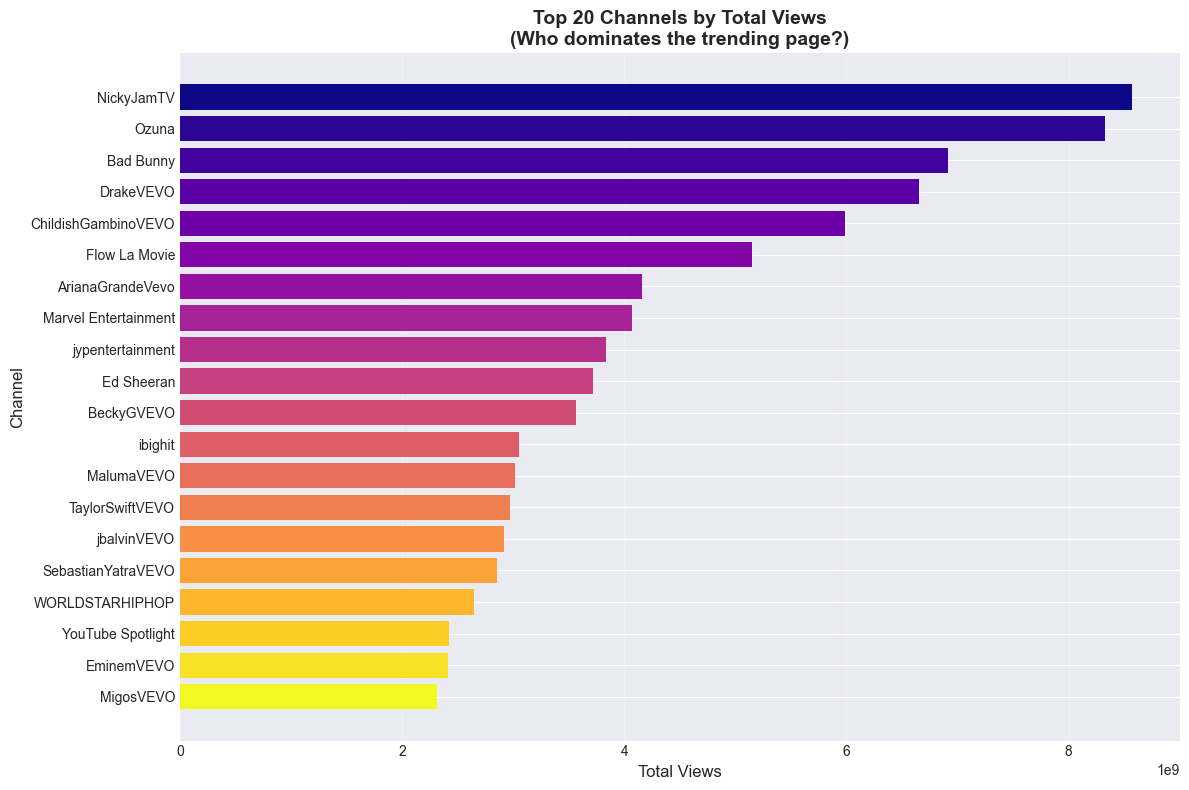

Insight: Top channel 'NickyJamTV' has 8,573,890,127 total views


In [30]:
plt.figure(figsize=(12, 8))

# Get top 20 channels by total views
channel_views = df_clean.groupby('channel_title')['views'].sum().sort_values(ascending=False).head(20)

# Create horizontal bar chart
colors = plt.cm.plasma(np.linspace(0, 1, len(channel_views)))
plt.barh(range(len(channel_views)), channel_views.values, color=colors)
plt.yticks(range(len(channel_views)), channel_views.index, fontsize=10)
plt.xlabel('Total Views', fontsize=12)
plt.ylabel('Channel', fontsize=12)
plt.title('Top 20 Channels by Total Views\n(Who dominates the trending page?)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Insight: Top channel '{channel_views.index[0]}' has {channel_views.values[0]:,.0f} total views")

### Visualization 7: Days to Trending Distribution (Histogram)

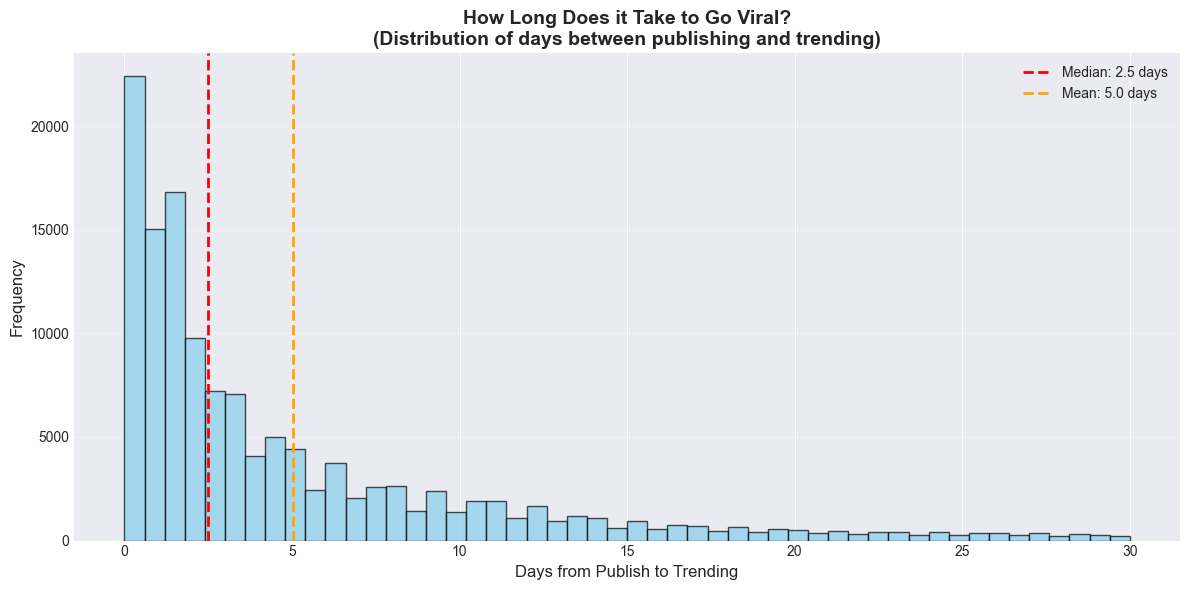

Insight: Most videos trend within 2 days of publishing


In [31]:
plt.figure(figsize=(12, 6))

# Filter reasonable values (remove outliers)
trending_days = df_clean[df_clean['days_to_trending'].between(0, 30)]['days_to_trending']

# Create histogram with KDE
plt.hist(trending_days, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Days from Publish to Trending', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('How Long Does it Take to Go Viral?\n(Distribution of days between publishing and trending)', 
          fontsize=14, fontweight='bold')
plt.axvline(trending_days.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {trending_days.median():.1f} days')
plt.axvline(trending_days.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {trending_days.mean():.1f} days')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Insight: Most videos trend within {trending_days.median():.0f} days of publishing")

### Visualization 8: Title Length Impact on Views (Violin Plot)

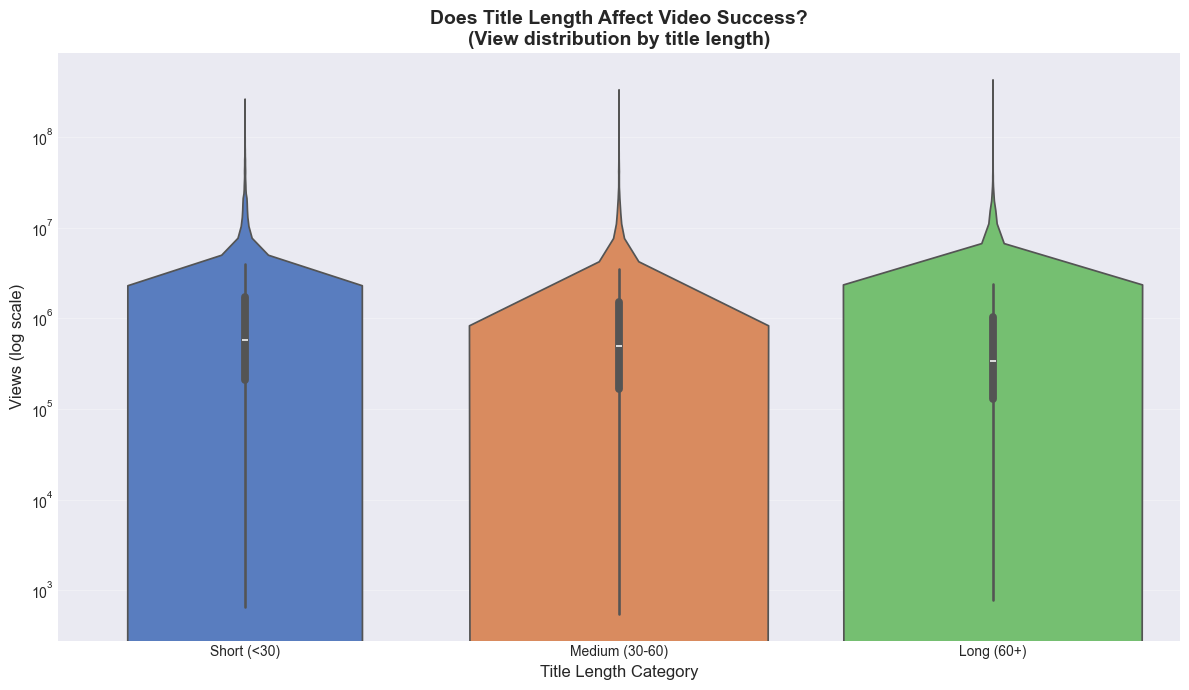


Insight: Median views by title length:
  Short (<30): 570,110 views
  Medium (30-60): 496,126 views
  Long (60+): 340,602 views


In [32]:
plt.figure(figsize=(12, 7))

# Categorize title lengths
def categorize_title_length(length):
    if length < 30:
        return 'Short (<30)'
    elif length < 60:
        return 'Medium (30-60)'
    else:
        return 'Long (60+)'

df_clean['title_length_category'] = df_clean['title_length'].apply(categorize_title_length)

# Create violin plot
sns.violinplot(data=df_clean, x='title_length_category', y='views', 
               palette='muted', order=['Short (<30)', 'Medium (30-60)', 'Long (60+)'])

plt.yscale('log')
plt.xlabel('Title Length Category', fontsize=12)
plt.ylabel('Views (log scale)', fontsize=12)
plt.title('Does Title Length Affect Video Success?\n(View distribution by title length)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate medians
median_views = df_clean.groupby('title_length_category')['views'].median()
print(f"\nInsight: Median views by title length:")
for cat in ['Short (<30)', 'Medium (30-60)', 'Long (60+)']:
    if cat in median_views.index:
        print(f"  {cat}: {median_views[cat]:,.0f} views")

### Visualization 9: Country Comparison (Grouped Bar Chart)

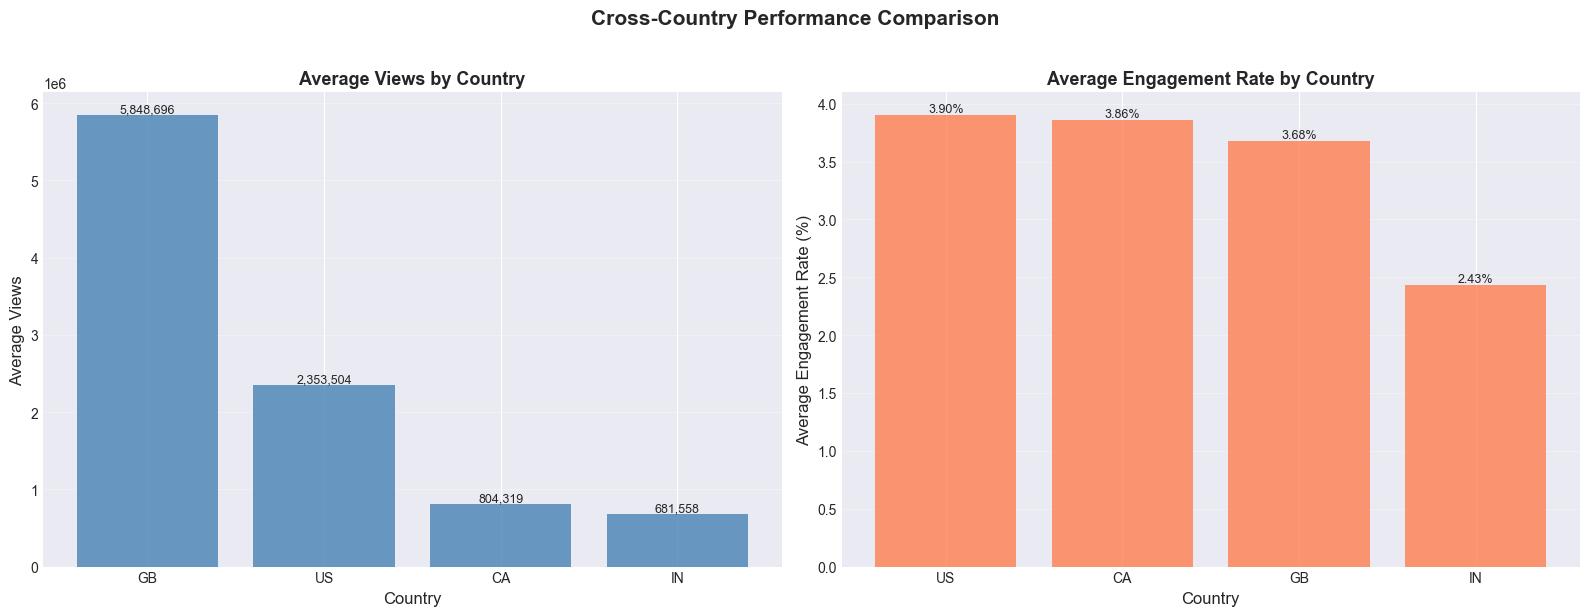

Insight: GB has highest avg views, US has highest engagement


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average views by country
country_views = df_clean.groupby('country')['views'].mean().sort_values(ascending=False)
axes[0].bar(country_views.index, country_views.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Country', fontsize=12)
axes[0].set_ylabel('Average Views', fontsize=12)
axes[0].set_title('Average Views by Country', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(country_views.values):
    axes[0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Average engagement by country
country_eng = df_clean.groupby('country')['engagement_rate'].mean().sort_values(ascending=False)
axes[1].bar(country_eng.index, country_eng.values, color='coral', alpha=0.8)
axes[1].set_xlabel('Country', fontsize=12)
axes[1].set_ylabel('Average Engagement Rate (%)', fontsize=12)
axes[1].set_title('Average Engagement Rate by Country', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(country_eng.values):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle('Cross-Country Performance Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Insight: {country_views.index[0]} has highest avg views, {country_eng.index[0]} has highest engagement")

### Visualization 10: Tag Count Analysis (Line Plot)

<Figure size 1400x700 with 0 Axes>

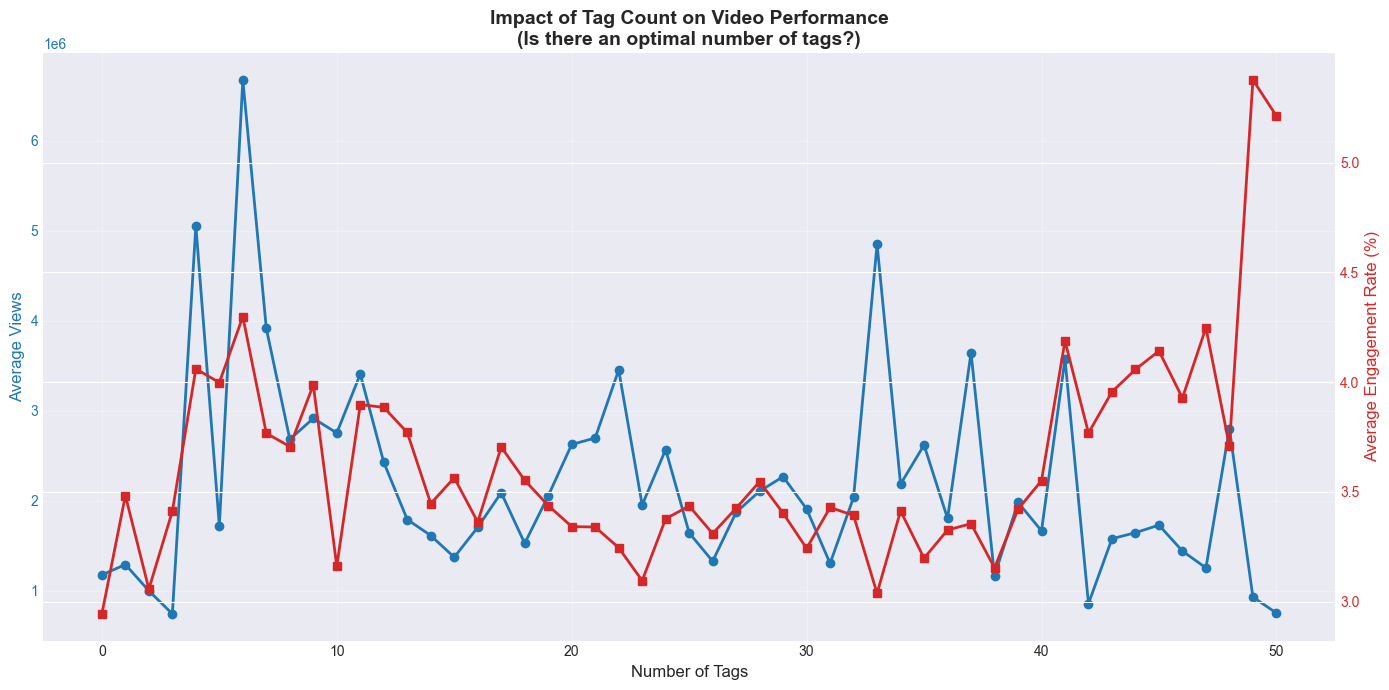

Insight: Optimal tag count for views: 6, for engagement: 49


In [34]:
plt.figure(figsize=(14, 7))

# Group by tag count and calculate average metrics
tag_analysis = df_clean[df_clean['tag_count'] <= 50].groupby('tag_count').agg({
    'views': 'mean',
    'engagement_rate': 'mean',
    'video_id': 'count'
}).reset_index()

# Filter groups with at least 10 videos
tag_analysis = tag_analysis[tag_analysis['video_id'] >= 10]

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot 1: Views
color = 'tab:blue'
ax1.set_xlabel('Number of Tags', fontsize=12)
ax1.set_ylabel('Average Views', color=color, fontsize=12)
ax1.plot(tag_analysis['tag_count'], tag_analysis['views'], 
         color=color, marker='o', linewidth=2, markersize=6, label='Avg Views')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot 2: Engagement rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Engagement Rate (%)', color=color, fontsize=12)
ax2.plot(tag_analysis['tag_count'], tag_analysis['engagement_rate'], 
         color=color, marker='s', linewidth=2, markersize=6, label='Avg Engagement')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Impact of Tag Count on Video Performance\n(Is there an optimal number of tags?)', 
          fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Find optimal tag count
optimal_tags_views = tag_analysis.loc[tag_analysis['views'].idxmax(), 'tag_count']
optimal_tags_eng = tag_analysis.loc[tag_analysis['engagement_rate'].idxmax(), 'tag_count']
print(f"Insight: Optimal tag count for views: {int(optimal_tags_views)}, for engagement: {int(optimal_tags_eng)}")

### Visualization 11: Correlation Heatmap

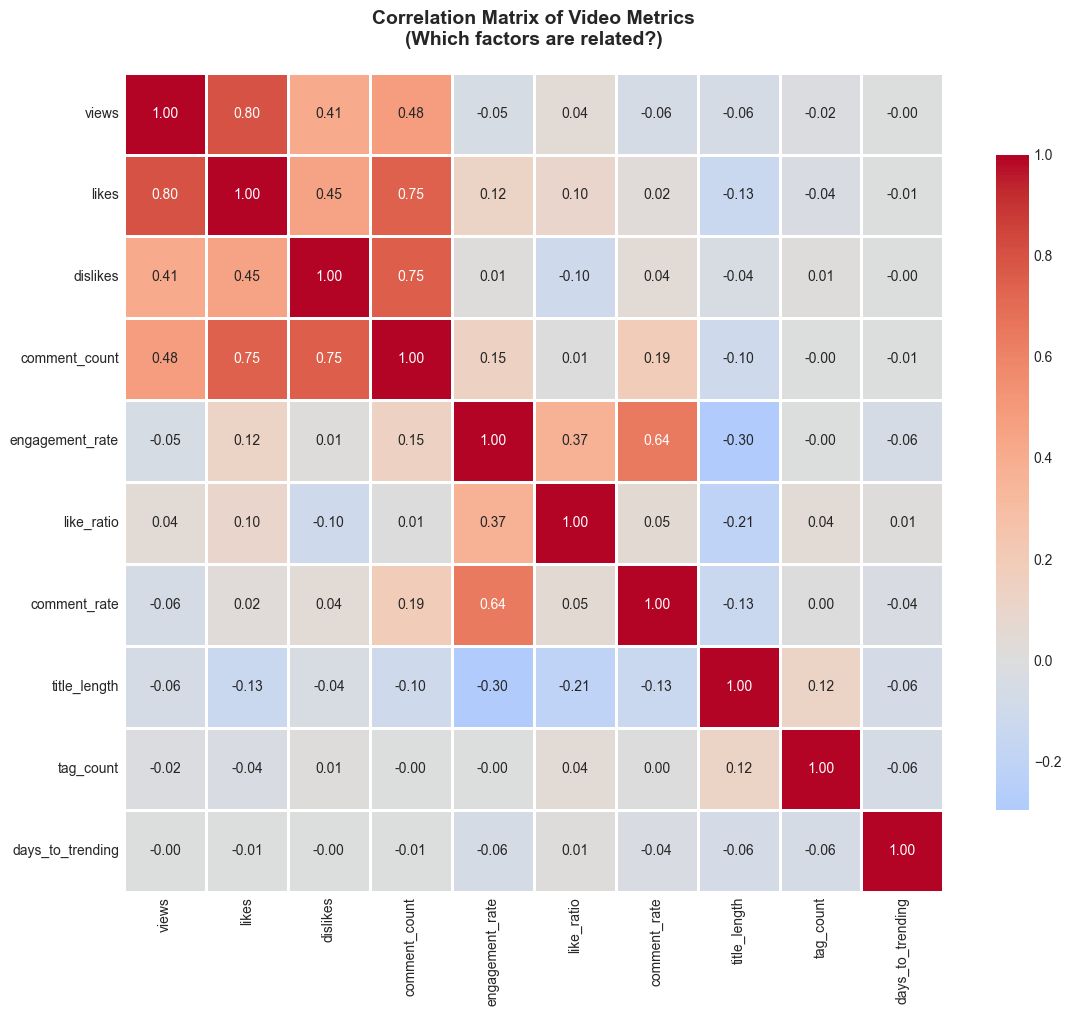

Insight: Strong correlations help identify key success factors


In [35]:
plt.figure(figsize=(12, 10))

# Select numerical columns for correlation
corr_cols = ['views', 'likes', 'dislikes', 'comment_count', 
             'engagement_rate', 'like_ratio', 'comment_rate',
             'title_length', 'tag_count', 'days_to_trending']

correlation_matrix = df_clean[corr_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix of Video Metrics\n(Which factors are related?)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Insight: Strong correlations help identify key success factors")

## 8. Key Findings Summary

Based on our analysis, here are the key factors that influence YouTube video success:

In [36]:
# Create a summary using loops and conditionals
print("="*80)
print("KEY INSIGHTS: What Makes a YouTube Video Successful?")
print("="*80)

findings = []

# Finding 1: Category impact
top_cat = df_clean.groupby('category_name')['views'].mean().idxmax()
findings.append(f"1. Category Matters: '{top_cat}' videos perform best")

# Finding 2: Engagement correlation
corr = df_clean[['views', 'engagement_rate']].corr().iloc[0, 1]
findings.append(f"2. Engagement is Key: {corr:.2f} correlation with views")

# Finding 3: Viral threshold
viral_videos = df_clean[df_clean['performance_class'] == 'Viral']
if len(viral_videos) > 0:
    viral_threshold = viral_videos['views'].min()
    findings.append(f"3. Viral Threshold: Videos need {viral_threshold:,.0f}+ views to go viral")

# Finding 4: Timing
best_publish_data = df_clean.groupby('publish_hour')['views'].mean()
best_hour = best_publish_data.idxmax()
findings.append(f"4. Best Publishing Time: {int(best_hour)}:00 hours")

# Finding 5: Speed matters
median_days = df_clean['days_to_trending'].median()
findings.append(f"5. Speed to Trending: Most successful videos trend within {median_days:.0f} days")

# Finding 6: Tags
tag_corr = df_clean[['tag_count', 'views']].corr().iloc[0, 1]
if tag_corr > 0:
    findings.append(f"6. Tags Help: Positive correlation ({tag_corr:.3f}) with views")
else:
    findings.append(f"6. Tags Have Limited Impact: Weak correlation ({tag_corr:.3f})")

# Print findings using a loop
for finding in findings:
    print(f"\n{finding}")

print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS")
print("="*80)

recommendations = [
    "→ Focus on high-engagement categories",
    "→ Optimize publishing time based on target audience",
    "→ Aim for early momentum (trending within first few days)",
    "→ Balance title length (not too short, not too long)",
    "→ Encourage viewer interaction (likes, comments) for better engagement",
    "→ Use appropriate number of tags (quality over quantity)"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*80)

KEY INSIGHTS: What Makes a YouTube Video Successful?

1. Category Matters: 'Music' videos perform best

2. Engagement is Key: -0.05 correlation with views

3. Viral Threshold: Videos need 3,974,840+ views to go viral

4. Best Publishing Time: 5:00 hours

5. Speed to Trending: Most successful videos trend within 2 days

6. Tags Have Limited Impact: Weak correlation (-0.020)

ACTIONABLE RECOMMENDATIONS
1. → Focus on high-engagement categories
2. → Optimize publishing time based on target audience
3. → Aim for early momentum (trending within first few days)
4. → Balance title length (not too short, not too long)
5. → Encourage viewer interaction (likes, comments) for better engagement
6. → Use appropriate number of tags (quality over quantity)



## 9. Export Cleaned Data for Database

Save the cleaned and processed data for use in SQL database and Streamlit dashboard.

In [37]:
# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Export main cleaned dataset
df_clean.to_csv('../data/cleaned_videos.csv', index=False, encoding='utf-8')
print(f"✓ Exported {len(df_clean):,} cleaned video records to ../data/cleaned_videos.csv")

# Export category mapping
category_df = df_clean[['category_id', 'category_name']].drop_duplicates()
category_df.to_csv('../data/categories.csv', index=False)
print(f"✓ Exported {len(category_df)} categories to ../data/categories.csv")

# Export aggregated statistics for quick dashboard loading
channel_stats = df_clean.groupby('channel_title').agg({
    'video_id': 'count',
    'views': ['sum', 'mean'],
    'engagement_rate': 'mean'
}).reset_index()
channel_stats.columns = ['channel_title', 'video_count', 'total_views', 'avg_views', 'avg_engagement']
channel_stats.to_csv('../data/channel_stats.csv', index=False)
print(f"✓ Exported channel statistics to ../data/channel_stats.csv")

print("\n✓ All data exported successfully!")
print("\nNext steps:")
print("  1. Run load_to_db.py to populate SQLite database")
print("  2. Run streamlit app for interactive dashboard")

✓ Exported 137,124 cleaned video records to ../data/cleaned_videos.csv
✓ Exported 18 categories to ../data/categories.csv
✓ Exported channel statistics to ../data/channel_stats.csv

✓ All data exported successfully!

Next steps:
  1. Run load_to_db.py to populate SQLite database
  2. Run streamlit app for interactive dashboard
